<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/demo_image_feature_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
! nvidia-smi

Tue Mar 30 16:10:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Demo for image feature representation
#### Qian Huang
#### Mar 29

Limited by sampling rate, bit depth and noise, the pixel map from a real sensor is not the optimal representation of an image. As we currently cannot go beyond computers' limit, data that represents an image should still be digital, but can live in a feature space, which can be reconstructed to an pixel map that we are familiar with.




The pipeline can be simplified as follows:

camera sensor data -> (preprocessing, like alignment) -> **measurement encoder** (compress data) -> measurement features -> **measurement decoder** -> estimation features -> **specific estimation decoder** -> specific estimation

On the camera end using features is mainly for compression. On the estimation end features are for better representation of an image.

The measurement encoder is implemented inside the camera head to reduce data size. Hence it should be concise and easy to deploy. Should be easily trained as a part of an autoencoder with camera sensor data. [DLACS](https://arxiv.org/pdf/1908.10903.pdf)

The measurement decoder should be able to transform features from measurment feature space to estimate feature space. Not a standard decoder. Can be regarded as demosaicnet/srnet/... but with different output type (features rather than pixel maps).

The estimation features should satisfy requirements of different decoders, so I feel it should contain more information that one pixel map needs. In this sense different decoders select the features that they want to produce the pixel map (e.g. pixel of different resolution). So the estimated features should be overcomplete. More data than a single pixel map.

Training estimation decoder is not trivial given the facts above. **One potential way may be building an autoencoder, fitting in a data chunk that composes of different kind of settings (resolutions?). To train a specific decoder, use ground truth pixel map of that specific setting to calculate the loss** (reference: [DeepVoxel](https://arxiv.org/pdf/1812.01024.pdf), [NeRF's review](https://arxiv.org/pdf/2003.08934.pdf), [Neural scene representation and rendering](https://www.gelecekburada.net/wp-content/uploads/google-yapay-zeka-perspektif-tamamlama-gelecek-burada.pdf)). Estimation feature space can be learned from synthetic data with high bit-depth, high resolution and no noise. Another way is to train the decoder at runtime


#### diagram

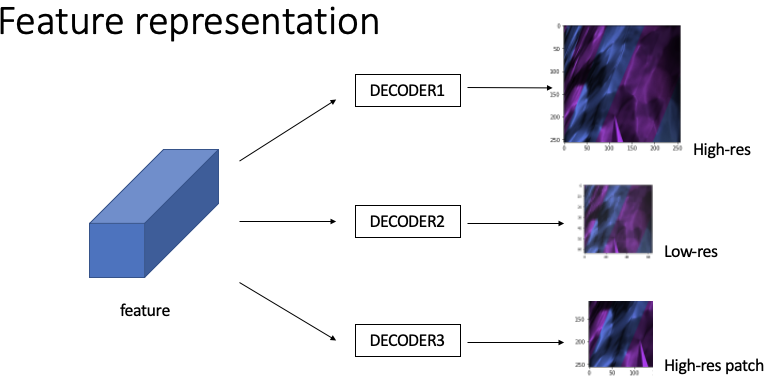

In [9]:
! unzip -q /content/drive/MyDrive/blender_512.zip -d scenes

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    npimg = (np.clip(npimg * 1.4 + 1.3, 0, 8)/8)**0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def load_exr(path):
        img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
random.seed(38)
np.random.seed(38)
torch.manual_seed(38)

In [12]:
import os
import cv2

class SynDataset(torch.utils.data.Dataset):
    def __init__(self, root, train = True, transform = None):
        self.root = root
        self.train = train
        self.transform = transform

    def __len__(self):
        if self.train:
            return 1600
        else:
            return 400
    
    def __getitem__(self, index):
        if self.train:
            X = load_exr(os.path.join(self.root, "scene{:04d}".format(index//100), 
                                  "Image", "Image{:04d}.exr".format(index % 100 + 1)))
        else:
            X = load_exr(os.path.join(self.root, "scene{:04d}".format(index//100 + 16), 
                                  "Image", "Image{:04d}.exr".format(index % 100 + 1)))
        X = self.randomCrop(X)
        X = torch.from_numpy(X.transpose(2, 0, 1)).float()
        return (X - 1.3)/1.4, (X[:, 64:64+128, 64:64+128] - 1.3)/1.4

    def randomCrop(self, img, size = 256):
        H, W, C = img.shape
        x = np.random.randint(0, H - size + 1)
        y = np.random.randint(0, W - size + 1)
        return img[x:x+size, y:y+size]

In [13]:
trainset = SynDataset(root='/content/scenes', train=True, transform=None) ## set root to '.' doesnt work
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testset = SynDataset(root='/content/scenes', train=False, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

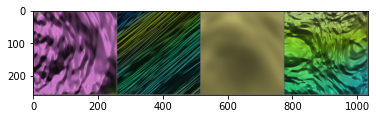

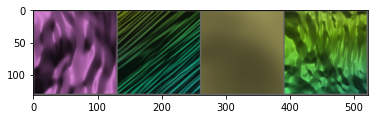

In [14]:
dataiter = iter(trainloader)
images, left_corners = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))
imshow(torchvision.utils.make_grid(left_corners[:4]))

In [15]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def deconv4x4(in_planes, out_planes, stride=2):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=stride, padding=1, bias=True)

In [16]:
class demoAutoEncoder(nn.Module):
    def __init__(self, in_planes, feature_planes):
        super(demoAutoEncoder, self).__init__()
        ''' encoder'''
        self.encoder = nn.Sequential(
            conv3x3(in_planes, 64, 2),
            nn.ReLU(inplace = True),
            conv3x3(64, 64, 2),
            nn.ReLU(inplace = True),
            conv3x3(64, feature_planes, 2),
            nn.ReLU(inplace = True),
        )

        '''decoder'''
        self.decoder = nn.Sequential(
            deconv4x4(feature_planes, 64),
            nn.ReLU(inplace = True),
            deconv4x4(64, in_planes),  ## different from colorAutoEncoder
            # nn.ReLU(inplace = True),
            # nn.Conv2d(32, in_planes, 5, stride=1, padding=2)
        )

        for name, m in self.named_modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
in_planes = 3
feature_planes = 128
model = demoAutoEncoder(in_planes, feature_planes).to(device)

#### load encoder only

In [19]:
state_dict = torch.load('color_ae_on_512_synthetic.pt')
encoder_dict = {k[8:]: v for k, v in state_dict.items() if "encoder" in k}
print(list(encoder_dict))
model.encoder.load_state_dict(encoder_dict)

['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias']


<All keys matched successfully>

In [20]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [21]:
def print_model_params(model):
    print("#total params:", sum(p.numel() for p in model.parameters()), end='')
    print(" | #trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

print_model_params(model)

#total params: 246787 | #trainable params: 134211


In [22]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)

In [23]:
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('epoch %d -- loss: %.3f' %
                (epoch+1, running_loss/(i+1)))
    running_loss = 0.0

print('Finished Training')

epoch 1 -- loss: 0.568
epoch 2 -- loss: 0.507
epoch 3 -- loss: 0.482
epoch 4 -- loss: 0.473
epoch 5 -- loss: 0.459
epoch 6 -- loss: 0.461
epoch 7 -- loss: 0.474
epoch 8 -- loss: 0.462
epoch 9 -- loss: 0.467
epoch 10 -- loss: 0.465
epoch 11 -- loss: 0.458
epoch 12 -- loss: 0.459
epoch 13 -- loss: 0.471
epoch 14 -- loss: 0.463
epoch 15 -- loss: 0.457
epoch 16 -- loss: 0.457
epoch 17 -- loss: 0.462
epoch 18 -- loss: 0.459
epoch 19 -- loss: 0.454
epoch 20 -- loss: 0.460
epoch 21 -- loss: 0.451
epoch 22 -- loss: 0.445
epoch 23 -- loss: 0.451


KeyboardInterrupt: ignored